<a href="https://colab.research.google.com/github/the-cryptozoologist/geo/blob/main/GEE/spectral-data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Multispectral Data

## Collecting optical remote sensing data

1) Target gets illuminated by solar radiation.

2) Radiation reflected from the target is captured by the optical sensor.

Optical data makes use of multispectral sensors that capture the reflected radiation within the electromagnetic spectrum.

Radiation in the: 
* Vis (0.4-0.75 µm)
* IR (0.75-1.4 µm)
* Short-wave IR (1.4-3 µm)
* Thermal (3-15 µm)
portions of the electromagnetic spectrum.

Optical data makes use of multispectral sensors that capture the reflected radiation within the electromagnetic spectrum.

Radiation in the: 
* Vis (0.4-0.75 µm)
* IR (0.75-1.4 µm)
* Short-wave IR (1.4-3 µm)
* Thermal (3-15 µm)
portions of the electromagnetic spectrum.


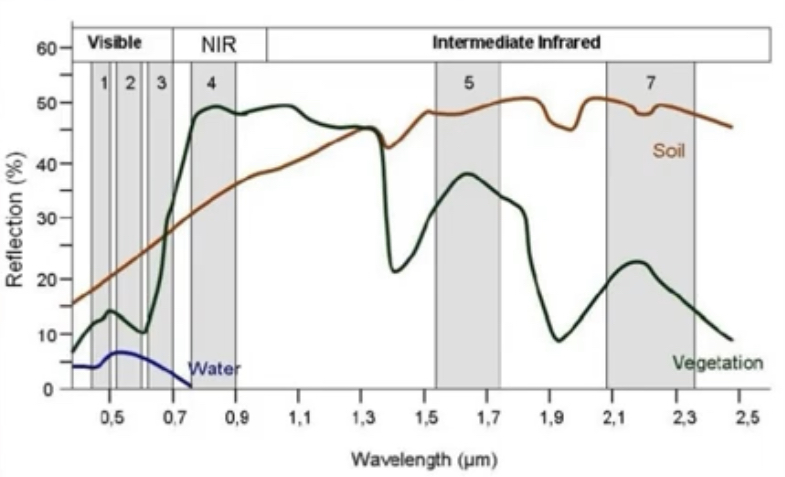



In [1]:
!pip install geemap

In [2]:
import geemap
import ee

ee.Authenticate()
ee.Initialize()

To authorize access needed by Earth Engine, open the following URL in a web browser and follow the instructions. If the web browser does not start automatically, please manually browse the URL below.

    https://accounts.google.com/o/oauth2/auth?client_id=517222506229-vsmmajv00ul0bs7p89v5m89qs8eb9359.apps.googleusercontent.com&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fearthengine+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdevstorage.full_control&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&response_type=code&code_challenge=JvrIKPacP1FWhjvKzVntBpNNF2cLOD4Za0A_DpRzehI&code_challenge_method=S256

The authorization workflow will generate a code, which you should paste in the box below. 
Enter verification code: 4/1AX4XfWjg3U-aqtN5cUokR2eLut8yEis8K-oxi20RzppWA8tvGPIx5Lb_PfA

Successfully saved authorization token.


In [3]:
wdpa_polygon = ee.FeatureCollection("WCMC/WDPA/current/polygons")

pa = wdpa_polygon.filter(ee.Filter.eq("NAME", "Golfe du Morbihan"))

sentinel2 = ee.ImageCollection("COPERNICUS/S2")

In [4]:
# Dry season 06-09

dry = sentinel2.filterBounds(pa).filterDate("2020-06-01", "2020-10-01")\
                                .sort("CLOUDY_PIXEL_PERCENTAGE", False)\
                                .mosaic().clip(pa)

In [5]:
# Wet season 10-05

wet = sentinel2.filterBounds(pa).filterDate("2019-10-01", "2020-05-31")\
                                .sort("CLOUDY_PIXEL_PERCENTAGE", False)\
                                .mosaic().clip(pa)

In [6]:
# NDWI

ndwi_dry = dry.normalizedDifference(["B3", "B8"])
ndwi_wet = wet.normalizedDifference(["B3", "B8"])

#Palettes

true_color = {"bands": ["B4","B3","B2"],
              "min": 0,
              "max": 3000}

water_palette = ["red", "yellow", "green","blue"]

In [7]:
Map = geemap.Map(center=[47.6532, -2.7855], zoom=10)
Map.addLayer(dry, true_color, "2020 Dry season true color")
Map.addLayerControl()
Map

Map(center=[47.6532, -2.7855], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(chi…

In [8]:
Map2 = geemap.Map(center=[47.6532, -2.7855], zoom=10)
Map2.addLayer(wet, true_color, "2019-20 Wet season true color")
Map2.addLayerControl()
Map2

Map(center=[47.6532, -2.7855], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(chi…

# Capturing vegetation structures

ALOS-PALSAR: synthetic aperture radar (SAR) data

SAR sensors:
* Illuminate the target surface with microwave pulses
* Backscatter (σ0) is captured by the sensor
* The structure of vegetation is captured

# Different illumination sources

The incident microwave pulses have various different wavelengths which can capture different attributes on the surface.

In JERS and ALOS-PALSAR sensors:

C-band: 4.8-7.5 cm

L-band: 15-30 cm

*Shorter wavelengths have a lower penetration ability*

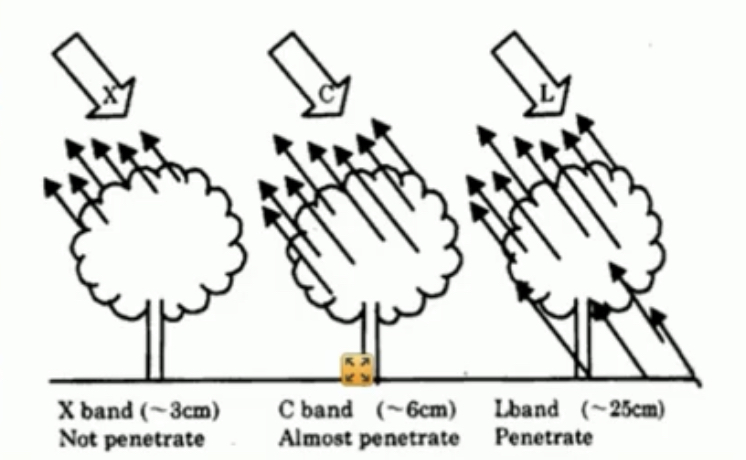

# Sentinel-1 data

In [13]:
sentinel1= ee.ImageCollection("COPERNICUS/S1_GRD").filterDate("2016-01-01", "2016-05-01")

In [14]:
vh = sentinel1.filter(ee.Filter.listContains("transmitterReceiverPolarisation", "VV"))\
              .filter(ee.Filter.listContains("transmitterReceiverPolarisation", "VH"))\
              .filter(ee.Filter.eq("instrumentMode", "IW"))

In [15]:
vhAscending = vh.filter(ee.Filter.eq("orbitProperties_pass", "ASCENDING"))
vhDescending = vh.filter(ee.Filter.eq("orbitProperties_pass", "DESCENDING"))

In [16]:
composite = ee.Image.cat([vhAscending.select("VH").mean(),
                          ee.ImageCollection(vhAscending.select("VV")\
                          .merge(vhDescending.select("VV"))).mean(),
                          vhDescending.select("VH").mean()])\
                          .focal_median()

# Sentinel-1 visualization

In [17]:
ffa_db = ee.Image(ee.ImageCollection("COPERNICUS/S1_GRD")\
                  .filterBounds(pa)\
                  .filterDate(ee.Date("2019-01-01"), ee.Date("2019-07-31"))\
                  .median().clip(pa))

In [18]:
rgb = ee.Image.rgb(ffa_db.select("VV"),
                   ffa_db.select("VH"),
                   ffa_db.select("VV").divide(ffa_db.select("VH")))

In [19]:
Map3 = geemap.Map(center=[47.6532, -2.7855], zoom=10)
Map3.add_basemap("SATELLITE")
Map3.addLayer(rgb, {"min": [-20,-20,0],
                    "max": [0,0,2]}, 
              "sentinel 1")

Map3.addLayerControl()
Map3

Map(center=[47.6532, -2.7855], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(chi…

# LANDSAT Time Series

In [20]:
!pip install geextract

  Created wheel for geextract: filename=geextract-0.5.0-py3-none-any.whl size=12848 sha256=291063893a60b70802c9a7804dd0d885cad70bc6e2ba65fff5fbb4e8cd3c21cb
  Stored in directory: /root/.cache/pip/wheels/2e/1a/8e/d123e50525e5101db2cee6f4686c6e7637534f83d4e87f0e5e
Successfully built geextract


In [21]:
from geextract import ts_extract, get_date
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=[10,5])

<Figure size 720x360 with 0 Axes>

<Figure size 720x360 with 0 Axes>

In [22]:
lat=47.6532
lon=-2.7855019

raw_dict=ts_extract(lon=lon, lat=lat, sensor="LT5",start=datetime(1984,1,1),radius=300)

In [23]:
def ndvi(x):
  try:
    return (x["B4"]-x["B3"])/(x["B4"]+x["B3"])
  except:
    pass

In [24]:
x= np.array([get_date(d["id"])for d in raw_dict])
y= np.array([ndvi(d) for d in raw_dict], dtype=np.float)

x= x[~np.isnan(y)]
y= y[~np.isnan(y)]

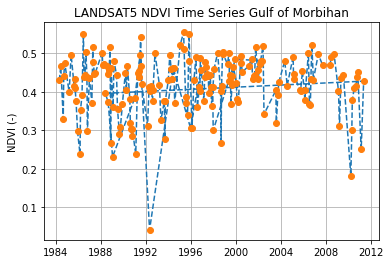

In [25]:
plt.plot_date(x,y,"--")
plt.plot_date(x,y)
plt.title("LANDSAT5 NDVI Time Series Gulf of Morbihan")
plt.ylabel("NDVI (-)")
plt.grid(True)

# HydroSHEDS Demo

In [26]:
Map = geemap.Map()

tr = ee.FeatureCollection("FAO/GAUL/2015/level0")\
                  .filter(ee.Filter.eq("ADM0_NAME", "Turkey"))

Map.centerObject(tr, 4)
Map.add_basemap("SATELLITE")
hydro_tr = ee.FeatureCollection("WWF/HydroSHEDS/v1/Basins/hybas_12")\
                  .filterBounds(tr)

Map.addLayer(hydro_tr, {}, "Basins")
Map.addLayerControl()
Map

# Point (29.5573, 40.6491) at 76m/px
# Basins: Feature (13 properties)
# COAST: 0
# DIST_MAIN: 0
#  DIST_SINK: 0
#  ENDO: 0
#  HYBAS_ID: 2120003340
#  MAIN_BAS: 2120003340
#  NEXT_DOWN: 0
#  NEXT_SINK: 2120003340
#  ORDER: 1
#  PFAF_ID: 211059040100
#  SORT: 2141
#  SUB_AREA: 112
#  UP_AREA: 284.9

Map(center=[39.13706909469105, 35.179063494008986], controls=(WidgetControl(options=['position', 'transparent_…

In [27]:
Map2 = geemap.Map(center=[40.6485, 29.5572],zoom=10)

karamursel = ee.FeatureCollection("WWF/HydroSHEDS/v1/Basins/hybas_12")\
                  .filter(ee.Filter.eq("PFAF_ID", 211059040100))
Map2.add_basemap("SATELLITE")
hydro = ee.FeatureCollection("WWF/HydroSHEDS/v1/Basins/hybas_12")\
                  .filterBounds(karamursel)

Map2.addLayer(hydro, {}, "Basins")
Map2.addLayerControl()
Map2

Map(center=[40.6485, 29.5572], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(chi…

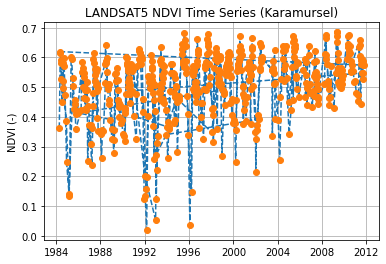

In [29]:
lat=40.6485
lon=29.5572

raw_dict=ts_extract(lon=lon, lat=lat, sensor="LT5",start=datetime(1984,1,1),radius=300)

def ndvi(x):
  try:
    return (x["B4"]-x["B3"])/(x["B4"]+x["B3"])
  except:
    pass

x= np.array([get_date(d["id"])for d in raw_dict])
y= np.array([ndvi(d) for d in raw_dict], dtype=np.float)

x= x[~np.isnan(y)]
y= y[~np.isnan(y)]


plt.plot_date(x,y,"--")
plt.plot_date(x,y)
plt.title("LANDSAT5 NDVI Time Series (Karamursel)")
plt.ylabel("NDVI (-)")
plt.grid(True)

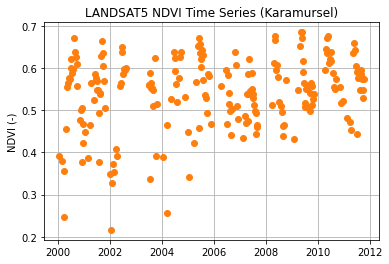

In [30]:
lat=40.6485
lon=29.5572

raw_dict=ts_extract(lon=lon, lat=lat, sensor="LT5",start=datetime(2000,1,1),radius=300)

def ndvi(x):
  try:
    return (x["B4"]-x["B3"])/(x["B4"]+x["B3"])
  except:
    pass

x= np.array([get_date(d["id"])for d in raw_dict])
y= np.array([ndvi(d) for d in raw_dict], dtype=np.float)

x= x[~np.isnan(y)]
y= y[~np.isnan(y)]


plt.plot_date(x,y," ")
plt.plot_date(x,y)
plt.title("LANDSAT5 NDVI Time Series (Karamursel)")
plt.ylabel("NDVI (-)")
plt.grid(True)

In [31]:
import pandas as pd
import altair as alt
import numpy as np
import folium

In [32]:
def create_reduce_region_function(geometry,
                                  reducer=ee.Reducer.mean(),
                                  scale=1000,
                                  crs='EPSG:4326',
                                  bestEffort=True,
                                  maxPixels=1e13,
                                  tileScale=4):

  def reduce_region_function(img):

    stat = img.reduceRegion(
        reducer=reducer,
        geometry=geometry,
        scale=scale,
        crs=crs,
        bestEffort=bestEffort,
        maxPixels=maxPixels,
        tileScale=tileScale)

    return ee.Feature(geometry, stat).set({'millis': img.date().millis()})
  return reduce_region_function

In [33]:
def fc_to_dict(fc):
  prop_names = fc.first().propertyNames()
  prop_lists = fc.reduceColumns(
      reducer=ee.Reducer.toList().repeat(prop_names.size()),
      selectors=prop_names).get('list')

  return ee.Dictionary.fromLists(prop_names, prop_lists)

In [34]:
today = ee.Date(pd.to_datetime('today'))
date_range = ee.DateRange(today.advance(-20, 'years'), today)

ndvi = ee.ImageCollection('MODIS/006/MOD13A2').filterDate(date_range).select('NDVI')

reduce_ndvi = create_reduce_region_function(
    geometry=karamursel, reducer=ee.Reducer.mean(), scale=1000, crs='EPSG:3310')

ndvi_stat_fc = ee.FeatureCollection(ndvi.map(reduce_ndvi)).filter(
    ee.Filter.notNull(ndvi.first().bandNames()))

In [39]:
Map3 = geemap.Map(center=[40.6485, 29.5572],zoom=15)
Map3.add_basemap("SATELLITE")

Map3.addLayer(ndvi_stat_fc, {}, "NDVI")
Map3.addLayerControl()
Map3

Map(center=[40.6485, 29.5572], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(chi…